# Chapter 3 - A Deep Dive Into Point Spreads

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr

In [2]:
df_static = pd.read_csv('odds.csv')

In [3]:
df_static.columns

Index(['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'team_home', 'score_home', 'score_away', 'team_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line', 'stadium',
       'stadium_neutral', 'weather_temperature', 'weather_wind_mph',
       'weather_humidity', 'weather_detail'],
      dtype='object')

In [3]:
# we should make some changes to the columns 
# we can drop some of the columns we don't need
# we can change to column names that fit our needs
# we'll simplify things by only using 2009-2018 games

# these are explicit columns we won't need
dropcols = ['schedule_date', 'schedule_playoff', 'stadium', 
            'stadium_neutral', 'schedule_playoff']

# we don't need any of the weather columns
weathercols = [c for c in df_static.columns if 'weather_' in c]

# columns we are keeping we want simplified names
renamecols = {'schedule_season': 'season', 
              'schedule_week': 'week', 
              'team_home': 'home_team',
              'team_away': 'away_team',
              'score_home': 'home_score',
              'score_away': 'away_score',
              'spread_favorite': 'spread',
              'team_favorite_id': 'favorite',
              'over_under_line': 'ou_line'
             }

# use to get seasons from 2009-2018
seasons = list(range(2009, 2019))

# group related columns together
colorder = ['season', 'week', 'home_team', 'away_team', 'favorite',
            'spread', 'ou_line', 'home_score', 'away_score']

# python statements can be nested in parentheses
# allows deviation from strict whitespace rules
# here we create a new dataframe from df_static
# .loc: find rows that are not playoff games
#       find columns that aren't in the drop or weather list
# .rename: use the name mapping in renamecols
# .loc: get the columns in the specified order
df = (
  df_static
  .loc[~df_static.schedule_playoff, [c for c in df_static.columns 
                                    if c not in dropcols + weathercols]]
  .rename(columns=renamecols)
  .query('season in @seasons')  
  .loc[:, colorder]
)

In [4]:
# looking at the dtypes, a couple of issues
# week should be integer; ou_line should be float
df.dtypes

season          int64
week           object
home_team      object
away_team      object
favorite       object
spread        float64
ou_line        object
home_score    float64
away_score    float64
dtype: object

In [5]:
# we want to convert these columns to int and float, respectively
# pandas method to_numeric allows us to 'coerce' errors into NaN
# we can later decide how to deal with these missing values (drop, fill, etc.)
df['week'] = df['week'].astype(int)
df['ou_line'] = pd.to_numeric(df['ou_line'], errors='coerce')

In [6]:
# a strange thing about this dataset is that it uses
# full team names for home and away team and then an ID code for favorite
# we will have to manipulate the data a bit to get it in the right format
# it will be easier to do this if we use standardized team codes
# looking at the codes, everything is normal except for PICK
# we'll have to deal with that scenario in a little bit
df['favorite'].unique()

array(['PIT', 'ARI', 'ATL', 'BAL', 'PHI', 'CIN', 'MIN', 'GB', 'HOU',
       'IND', 'NO', 'NYG', 'SEA', 'DAL', 'NE', 'LAC', 'BUF', 'DEN', 'JAX',
       'KC', 'SF', 'TEN', 'WAS', 'NYJ', 'CHI', 'MIA', 'CAR', 'DET', 'OAK',
       'CLE', 'TB', 'LAR', 'PICK'], dtype=object)

In [7]:
# we'll define a function that converts team names to team codes or IDs,
# the familiar two or three character strings (PIT, DAL, CHI, SF, etc.)
# TEAM_CODES is a dictionary. The key is the team code, the value is a list of codes/names
# the basic idea is to first look for a direct match, which confirms an accurate team code
# if no match is found, loop through the lists and look for a match
def get_team_code(team):
    """Standardizes team code across sites

    Args:
        team (str): the code or team name

    Returns:
        str: 2-3 letter team code, ATL, BAL, etc.

    Examples:
        >>>team_code('Ravens')
        'BAL'

        >>>team_code('JAC')
        'JAX'
    """
    TEAM_CODES = {
        'ARI': ['ARI', 'Arizona Cardinals', 'Cardinals', 'Arizona', 'crd'],
        'ATL': ['ATL', 'Atlanta Falcons', 'Falcons', 'Atlanta', 'atl'],
        'BAL': ['BAL', 'Baltimore Ravens', 'Ravens', 'Baltimore', 'rav'],
        'BUF': ['BUF', 'Buffalo Bills', 'Bills', 'Buffalo', 'buf'],
        'CAR': ['CAR', 'Carolina Panthers', 'Panthers', 'Carolina', 'car'],
        'CHI': ['CHI', 'Chicago Bears', 'Bears', 'Chicago', 'chi'],
        'CIN': ['CIN', 'Cincinnati Bengals', 'Bengals', 'Cincinnati', 'cin'],
        'CLE': ['CLE', 'Cleveland Browns', 'Browns', 'Cleveland', 'cle'],
        'DAL': ['DAL', 'Dallas Cowboys', 'Cowboys', 'Dallas', 'dal'],
        'DEN': ['DEN', 'Denver Broncos', 'Broncos', 'Denver', 'den'],
        'DET': ['DET', 'Detroit Lions', 'Lions', 'Detroit', 'det'],
        'GB': ['GB', 'Green Bay Packers', 'Packers', 'Green Bay', 'GNB', 'gnb'],
        'HOU': ['HOU', 'Houston Texans', 'Texans', 'Houston', 'htx'],
        'IND': ['IND', 'Indianapolis Colts', 'Colts', 'Indianapolis', 'clt'],
        'JAX': ['JAC', 'JAC', 'Jacksonville Jaguars', 'Jaguars', 'Jacksonville', 'jac', 'jax'],
        'KC': ['KC', 'Kansas City Chiefs', 'Chiefs', 'Kansas City', 'kan', 'KAN'],
        'LAC': ['LAC', 'Los Angeles Chargers', 'LA Chargers', 'San Diego Chargers', 'Chargers', 'San Diego', 'SD', 'sdg', 'SDG'],
        'LAR': ['LAR', 'LA', 'Los Angeles Rams', 'LA Rams', 'St. Louis Rams', 'Rams', 'St. Louis', 'ram'],
        'MIA': ['MIA', 'Miami Dolphins', 'Dolphins', 'Miami', 'mia'],
        'MIN': ['MIN', 'Minnesota Vikings', 'Vikings', 'Minnesota', 'min'],
        'NE': ['NE', 'New England Patriots', 'Patriots', 'New England', 'NEP', 'nwe', 'NWE'],
        'NO': ['NO', 'New Orleans Saints', 'Saints', 'New Orleans', 'NOS', 'nor', 'NOR'],
        'NYG': ['NYG', 'New York Giants', 'Giants', 'nyg'],
        'NYJ': ['NYJ', 'New York Jets', 'Jets', 'nyj'],
        'OAK': ['OAK', 'Oakland Raiders', 'Raiders', 'Oakland', 'rai'],
        'PHI': ['PHI', 'Philadelphia Eagles', 'Eagles', 'Philadelphia', 'phi'],
        'PIT': ['PIT', 'Pittsburgh Steelers', 'Steelers', 'Pittsburgh', 'pit'],
        'SF': ['SF', 'San Francisco 49ers', '49ers', 'SFO', 'San Francisco', 'sfo'],
        'SEA': ['SEA', 'Seattle Seahawks', 'Seahawks', 'Seattle', 'sea'],
        'TB': ['TB', 'Tampa Bay Buccaneers', 'Buccaneers', 'TBO', 'tam', 'TAM', 'Tampa', 'Tampa Bay'],
        'TEN': ['TEN', 'Tennessee Titans', 'Titans', 'Tennessee', 'oti'],
        'WAS': ['WAS', 'Washington Redskins', 'Redskins', 'Washington', 'was']
    }

    if team in TEAM_CODES:
        return team
    
    matches = [(k, v) for k, v in TEAM_CODES.items()
               if (team in v or
                   team.title() in v or
                   team.lower() in v or
                   team.upper() in v)
               ]
    
    if len(matches) == 1:
        return matches[0][0]
    raise ValueError(f'no match for {team}')

In [8]:
# for simplicity sake, will treat the home team as the favorite in pickem
df['favorite'] = df.apply(lambda row: row.home_team if row.favorite == 'PICK'
                                      else row.favorite, axis=1) 

In [9]:
# now we can standardize all of the team codes
df['home_team'] = df['home_team'].apply(get_team_code)
df['away_team'] = df['away_team'].apply(get_team_code)
df['favorite'] = df['favorite'].apply(get_team_code)

In [10]:
# add columns for implied team totals
df['favorite_implied'] = (df['ou_line'] - df['spread']) / 2
df['underdog_implied'] = (df['ou_line'] + df['spread']) / 2

In [11]:
# add boolean column indicating if favorite is home_team
df['home_favorite'] = df['home_team'] == df['favorite']

In [12]:
# get the actual score for the favorite and the underdog
df['score_favorite'] = df.apply(lambda row: row.home_score 
                                                  if row.home_favorite 
                                                  else row.away_score, 
                                      axis=1)

df['score_underdog'] = df.apply(lambda row: row.away_score 
                                                  if row.home_favorite 
                                                  else row.home_score, 
                                      axis=1)

In [13]:
# calculate the error of the implied totals and ou_line
df['favorite_implied_error'] = df['favorite_implied'] - df['score_favorite']
df['underdog_implied_error'] = df['underdog_implied'] - df['score_underdog']
df['ou_error'] = df['ou_line'] - (df['score_favorite'] + df['score_underdog'])

In [14]:
# boolean for whether the favorite won the game
# boolean for whether the favorite covered
# boolean for whether ou hit
df['favorite_win'] = df['score_favorite'] > df['score_underdog']
df['favorite_cover'] = df['score_favorite'] + df['spread'] > df['score_underdog']
df['ou_over'] = df['ou_line'] < df['score_favorite'] + df['score_underdog']

In [15]:
# drop the unneeded columns
df = df.drop(['home_team', 'away_team', 'favorite', 'home_score', 'away_score'], axis=1)

In [16]:
df.head()

,season,week,spread,ou_line,favorite_implied,underdog_implied,home_favorite,score_favorite,score_underdog,favorite_implied_error,underdog_implied_error,ou_error,favorite_win,favorite_cover,ou_over
9741,2009,1,-6.5,35.0,20.75,14.25,True,13.0,10.0,7.75,4.25,12.0,True,False,False
9742,2009,1,-4.5,45.0,24.75,20.25,True,16.0,20.0,8.75,0.25,9.0,False,False,False
9743,2009,1,-4.0,44.5,24.25,20.25,True,19.0,7.0,5.25,13.25,18.5,True,True,False
9744,2009,1,-13.0,36.5,24.75,11.75,True,38.0,24.0,-13.25,-12.25,-25.5,True,True,True
9745,2009,1,-2.5,43.5,23.00,20.50,False,38.0,10.0,-15.00,10.50,-4.5,True,True,True


## Over/Under Lines

In [33]:
display(df['ou_error'].describe())
display(iqr(df['ou_error']))

count    2560.000000
mean       -0.284961
std        13.298514
min       -49.000000
25%        -8.500000
50%         0.500000
75%         9.000000
max        39.500000
Name: ou_error, dtype: float64

17.5

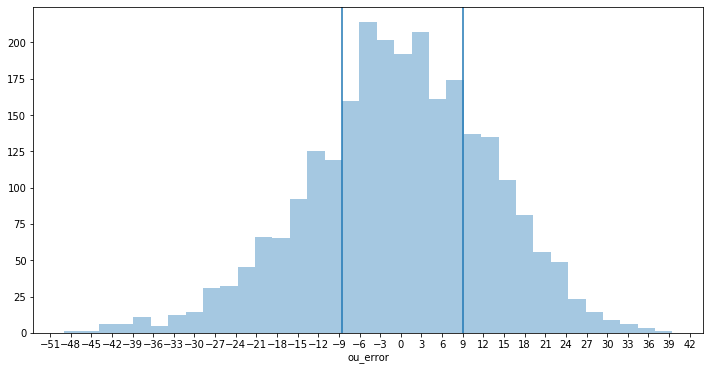

In [32]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(df['ou_error'], norm_hist=False, kde=False)
ax.xaxis.set_major_locator(MultipleLocator(3))
plt.axvline(np.percentile(df['ou_error'], 25), 0, 1)
plt.axvline(np.percentile(df['ou_error'], 75), 0, 1)

In [42]:
count, division = np.histogram(df['ou_error'])
pd.DataFrame([count, division])

,0,1,2,3,4,5,6,7,8,9,10
0,11.0,31.00,100.0,245.00,514.0,705.00,530.0,319.00,94.0,11.00,NaN
1,-49.0,-40.15,-31.3,-22.45,-13.6,-4.75,4.1,12.95,21.8,30.65,39.5


## Implied totals

In [43]:
display(df['favorite_implied_error'].describe())
display(iqr(df['favorite_implied_error']))

count    2560.000000
mean       -0.141895
std         9.714826
min       -35.750000
25%        -6.250000
50%         0.250000
75%         6.500000
max        26.000000
Name: favorite_implied_error, dtype: float64

12.75

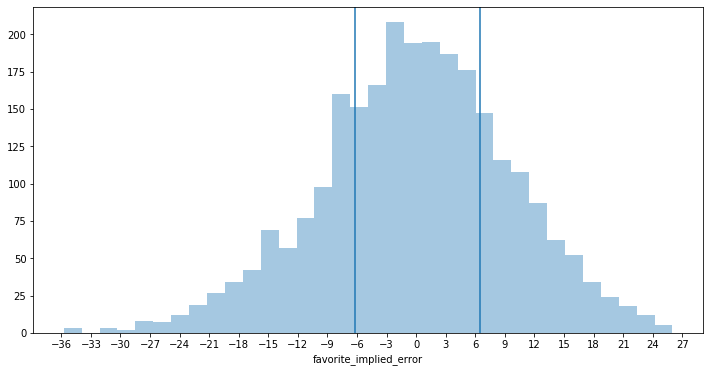

In [44]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(df['favorite_implied_error'], norm_hist=False, kde=False)
ax.xaxis.set_major_locator(MultipleLocator(3))
plt.axvline(np.percentile(df['favorite_implied_error'], 25), 0, 1)
plt.axvline(np.percentile(df['favorite_implied_error'], 75), 0, 1)

In [45]:
display(df['underdog_implied_error'].describe())
display(iqr(df['underdog_implied_error']))

count    2560.000000
mean       -0.143066
std         9.195614
min       -41.000000
25%        -6.000000
50%         0.250000
75%         6.250000
max        25.750000
Name: underdog_implied_error, dtype: float64

12.25

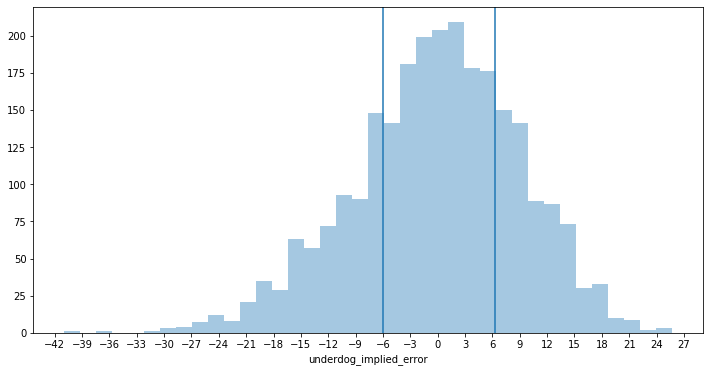

In [46]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(df['underdog_implied_error'], norm_hist=False, kde=False)
ax.xaxis.set_major_locator(MultipleLocator(3))
plt.axvline(np.percentile(df['underdog_implied_error'], 25), 0, 1)
plt.axvline(np.percentile(df['underdog_implied_error'], 75), 0, 1)